In [1]:
import numpy as np
from vivarium import Vivarium
from spatio_flux import PROCESS_DICT, TYPES_DICT, build_path, render_path

## Make a Vivarium
view available types and processes

In [2]:
# TODO -- make a spatio-flux specific Vivarium with the the core preloaded
vi = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

In [3]:
# view the available types
vi.get_types()

['',
 'length*temperature',
 'mass/current*time^2',
 'length^3/time',
 'mass/length*time^2',
 'length*mass/current^2*time^2',
 'map',
 'quote',
 'length/mass',
 'boolean',
 'current*length^2',
 'positive_float',
 'union',
 'array',
 'length/time^2',
 'tuple',
 'length^0_5*mass^0_5/time',
 'reaction',
 'length^2/time^2',
 'schema',
 'length^2/time',
 'length*mass/time^2',
 'float',
 'mass/time^3',
 'mass',
 'length/time',
 'length^2*mass/time^3',
 'mass/length',
 'process',
 'substance/time',
 'printing_unit/length',
 'composite',
 'length^2*mass/current*time^2',
 'bounds',
 'substance',
 'printing_unit',
 '/temperature*time',
 'interval',
 'length^3/mass*time^2',
 'any',
 'length^2*mass/current*time^3',
 '/time',
 'current',
 'time^2/length',
 'kinetics',
 'time/length',
 'length^3',
 'mass^0_5/length^0_5*time',
 'step',
 '/length',
 'mass/length^3',
 'path',
 'integer',
 'wires',
 '/substance',
 'length^2',
 'protocol',
 'string',
 'length^0_5*mass^0_5',
 'tree',
 'mass^0_5/length^1_5

In [4]:
# view the available processes
vi.get_processes()

['composite',
 'DynamicFBA',
 'DiffusionAdvection',
 'ram-emitter',
 'json-emitter',
 'MinimalParticle',
 'Particles',
 'console-emitter']

## dFBA

Dynamic Flux Balance Analysis (dFBA) extends traditional Flux Balance Analysis (FBA) to model the dynamic behavior of metabolic networks over time, allowing for the simulation of growth and substrate consumption in a changing environment.

In [5]:
# inspect the config schema for the 'increase' process
vi.process_config('DynamicFBA')

{'model_file': 'string',
 'kinetic_params': 'map[tuple[float,float]]',
 'substrate_update_reactions': 'map[string]',
 'biomass_identifier': 'string',
 'bounds': 'map[bounds]'}

In [6]:
vi.core.default(vi.process_config('DynamicFBA')) # TODO use default to

{'model_file': '',
 'kinetic_params': {},
 'substrate_update_reactions': {},
 'biomass_identifier': '',
 'bounds': {}}

In [7]:
dfba_config  = vi.process_config('DynamicFBA', dataclass=True)  # TODO -- make this work

Error finding process DynamicFBA: 'type_parameters'


In [8]:
# TODO - enable get_dataclass to work with the new process
# dfba_config  = v.get_dataclass('DynamicFBA')
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }
}

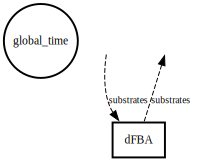

In [9]:
# make the vivarium
v = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

# add a dynamic FBA process called 'dFBA'
v.add_process(name="dFBA",
              process_id="DynamicFBA",
              config=dfba_config,
              )
v.diagram(dpi='70')

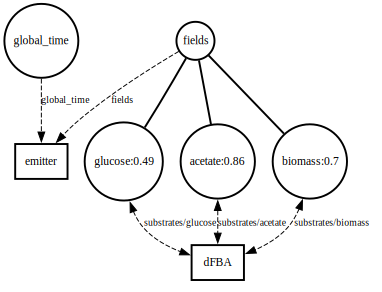

In [10]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]

for mol_id in mol_ids:
    v.add_object(
        name=mol_id,
        path=path,
        value=np.random.rand()
    )

v.connect_process(
    name="dFBA",
    inputs={
            "substrates": {
                mol_id: build_path(path, mol_id)
                for mol_id in mol_ids}
        },
    outputs={
            "substrates": {
                mol_id: build_path(path, mol_id)
                for mol_id in mol_ids}
        }
)

# add an emitter to save results
v.add_emitter()

# TODO -- show_values does not work
v.diagram(dpi='70', show_values=True)

In [11]:
v.set_value(path = ['fields', 'glucose'], value=10)
v.set_value(path = ['fields', 'biomass'], value=0.1)
field = v.get_value(['fields'])
print(field)

{'glucose': 10, 'acetate': 0.8574468550798992, 'biomass': 0.1}


In [12]:
v.save(filename='dFBA_t0')

Saved file: out/dFBA_t0.json


In [13]:
# run the simulation for 10 time units
v.run(interval=60)

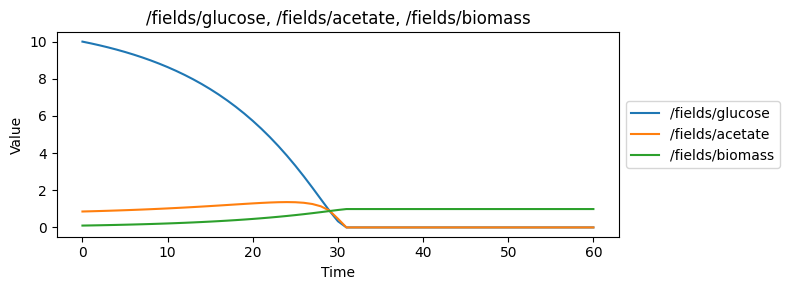

In [14]:
v.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [
            '/fields/glucose',
            '/fields/acetate',
            '/fields/biomass'
        ]
    ]
)

## Spatial dFBA

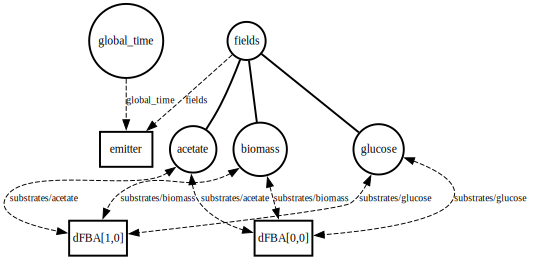

In [15]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
rows = 2
columns = 1

# make the vivarium
v2 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=path,
        value=np.random.rand(rows, columns)
    )

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):
        dfba_name = f"dFBA[{i},{j}]"

        # add a process for this location
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config,
        )
        v2.connect_process(
            name=dfba_name,
            inputs={"substrates": {
                        mol_id: build_path(path, mol_id, i, j)
                        for mol_id in mol_ids}},
            outputs={"substrates": {
                        mol_id: build_path(path, mol_id, i, j)
                        for mol_id in mol_ids}}
        )

# add an emitter to save results
v2.add_emitter()

v2.diagram(dpi='70')

In [16]:
# change some initial values
v2.set_value(path = ['fields', 'glucose', 0, 0], value=10)
v2.set_value(path = ['fields', 'biomass', 0, 0], value=0.1)
field = v2.get_value(['fields'])
print(field)

{'glucose': array([[10.        ],
       [ 0.58612209]]), 'acetate': array([[0.52601002],
       [0.40441955]]), 'biomass': array([[0.1       ],
       [0.76308133]])}


In [17]:
v2.run(60)

In [18]:
v2.get_timeseries(as_dataframe=True)

,/global_time,/fields/glucose,/fields/acetate,/fields/biomass
0,0.0,"[[10.0], [0.5861220875230632]]","[[0.5260100191061267], [0.4044195512069694]]","[[0.1], [0.7630813291285189]]"
1,1.0,"[[9.904761904761905], [0.17432784568173437]]","[[0.5381180713022159], [0.0]]","[[0.1079432568708625], [0.8092353115410553]]"
2,2.0,"[[9.80200585245463], [0.0]]","[[0.5510939587783568], [0.0]]","[[0.11651530697082768], [0.824290946269276]]"
3,3.0,"[[9.691145527078628], [0.0]]","[[0.5649887895278443], [0.0]]","[[0.12576552148631978], [0.824290946269276]]"
4,4.0,"[[9.571550338512791], [0.0]]","[[0.5798541666910404], [0.0]]","[[0.13574706721093277], [0.824290946269276]]"
...,...,...,...,...
56,56.0,"[[0.0], [0.0]]","[[0.0], [0.0]]","[[0.9776215866230703], [0.824290946269276]]"
57,57.0,"[[0.0], [0.0]]","[[0.0], [0.0]]","[[0.9776215866230703], [0.824290946269276]]"
58,58.0,"[[0.0], [0.0]]","[[0.0], [0.0]]","[[0.9776215866230703], [0.824290946269276]]"
59,59.0,"[[0.0], [0.0]]","[[0.0], [0.0]]","[[0.9776215866230703], [0.824290946269276]]"


In [19]:
# get a list of all the paths so they can be plotted together in a single graph
all_paths = []
for i in range(rows):
    for j in range(columns):
        # get the paths for this location
        location_path = []
        for mol_id in mol_ids:
            this_path = build_path(path, mol_id, i, j)
            rendered_path = render_path(this_path)
            location_path.append(rendered_path)
        all_paths.append(location_path)
# print(all_paths)

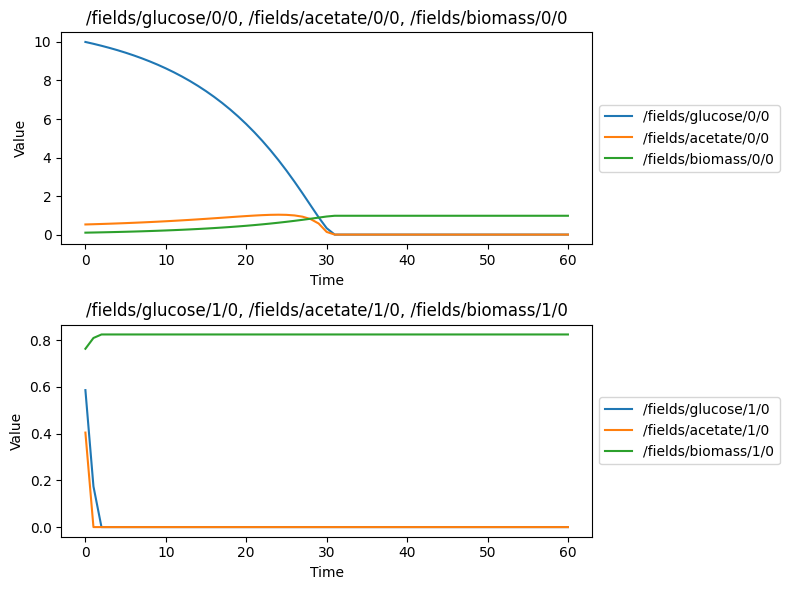

In [20]:
v2.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=all_paths
)

In [21]:
# v2.show_video()

## Diffusion/Advection

This approach models the physical processes of diffusion and advection in two dimensions, providing a way to simulate how substances spread and are transported across a spatial domain, essential for understanding patterns of concentration over time and space.

In [22]:
vi.core.default(vi.process_config('DiffusionAdvection'))

{'n_bins': (0, 0),
 'bounds': (0.0, 0.0),
 'default_diffusion_rate': 0.1,
 'default_diffusion_dt': 0.1,
 'diffusion_coeffs': {},
 'advection_coeffs': {}}

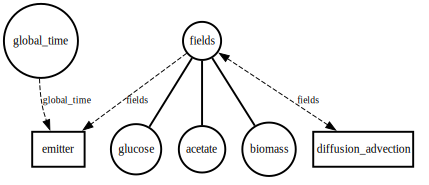

In [23]:
bounds = (10.0, 10.0)
n_bins = (10, 10)
mol_ids = [
    'glucose',
    'acetate',
    'biomass'
]
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {
    'biomass': (0, -0.1)
}
path = ['fields']

v3 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

for mol_id in mol_ids:
    v3.add_object(
        name=mol_id,
        path=path,
        value=np.random.rand(n_bins[0], n_bins[1])
    )

v3.add_process(name='diffusion_advection',
               process_id='DiffusionAdvection',
               config={
                   'n_bins': n_bins,
                   'bounds': bounds,
                   'default_diffusion_rate': diffusion_rate,
                   'default_diffusion_dt': diffusion_dt,
                   # 'diffusion_coeffs': diffusion_coeffs_all,
                   'advection_coeffs': advection_coeffs,
               },
               inputs={'fields': ['fields']},
               outputs={'fields': ['fields']}
               )

# add an emitter to save results
v3.add_emitter()

v3.diagram(dpi='70')

In [24]:
v3.run(60)

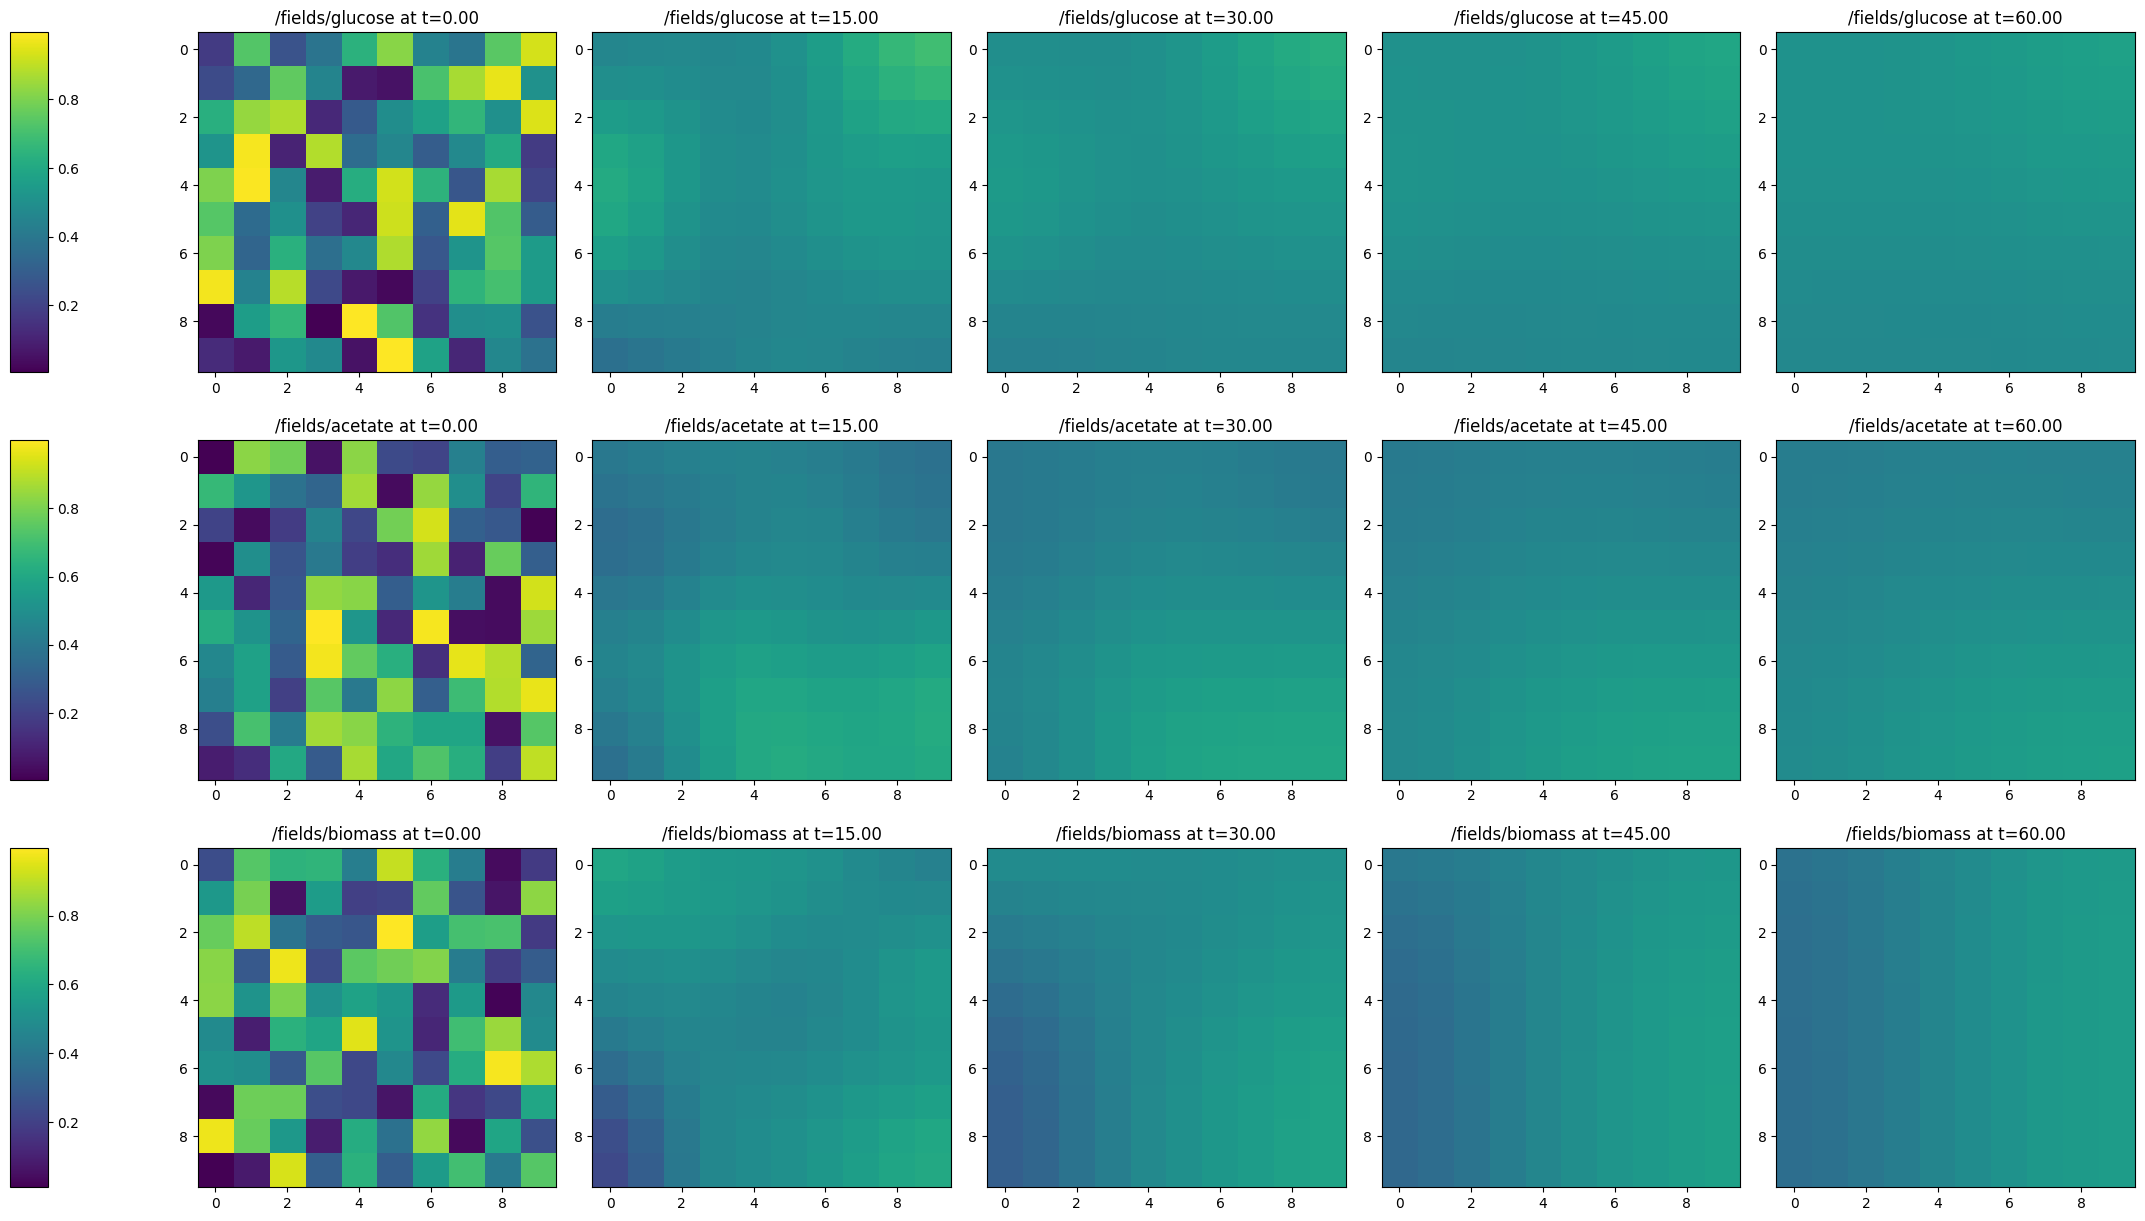

In [25]:
v3.plot_snapshots(n_snapshots=5)

In [26]:
# v3.show_video()

## COMETS (Computation Of Microbial Ecosystems in Time and Space)

COMETS combines dynamic FBA with spatially resolved physical processes (like diffusion and advection) to simulate the growth, metabolism, and interaction of microbial communities within a structured two-dimensional environment, capturing both biological and physical complexities.

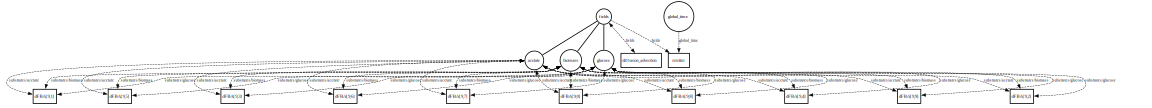

In [27]:
bounds = (10.0, 10.0)
n_bins = (10, 10)
mol_ids = [
    'glucose',
    'acetate',
    'biomass'
]
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {
    'biomass': (0, -0.1)
}
path = ['fields']

v4 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

# create the molecular fields
# for mol_id in mol_ids:
v4.add_object(
    name='glucose',
    path=path,
    value=np.random.rand(n_bins[0], n_bins[1])
)
v4.add_object(
    name='biomass',
    path=path,
    value=np.ones((n_bins[0], n_bins[1])) * 0.01
)
v4.add_object(
    name='acetate',
    path=path,
    value=np.zeros((n_bins[0], n_bins[1]))
)

# add a diffusion/advection process
v4.add_process(name='diffusion_advection',
               process_id='DiffusionAdvection',
               config={
                   'n_bins': n_bins,
                   'bounds': bounds,
                   'default_diffusion_rate': diffusion_rate,
                   'default_diffusion_dt': diffusion_dt,
                   'advection_coeffs': advection_coeffs},
               inputs={'fields': path},
               outputs={'fields': path}
               )

# add a dynamic FBA process at every location
for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        dfba_name = f"dFBA[{i},{j}]"

        # add a process for this location
        v4.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config,
        )
        v4.connect_process(
            name=dfba_name,
            inputs={"substrates": {
                        mol_id: build_path(path, mol_id, i, j)
                        for mol_id in mol_ids}},
            outputs={"substrates": {
                        mol_id: build_path(path, mol_id, i, j)
                        for mol_id in mol_ids}}
        )

# add an emitter to save results
v4.add_emitter()

v4.diagram(dpi='70',
           remove_nodes=[f"/dFBA[{i},{j}]" for i in range(n_bins[0]-1) for j in range(n_bins[1])]
           )

In [28]:
v4.run(60)

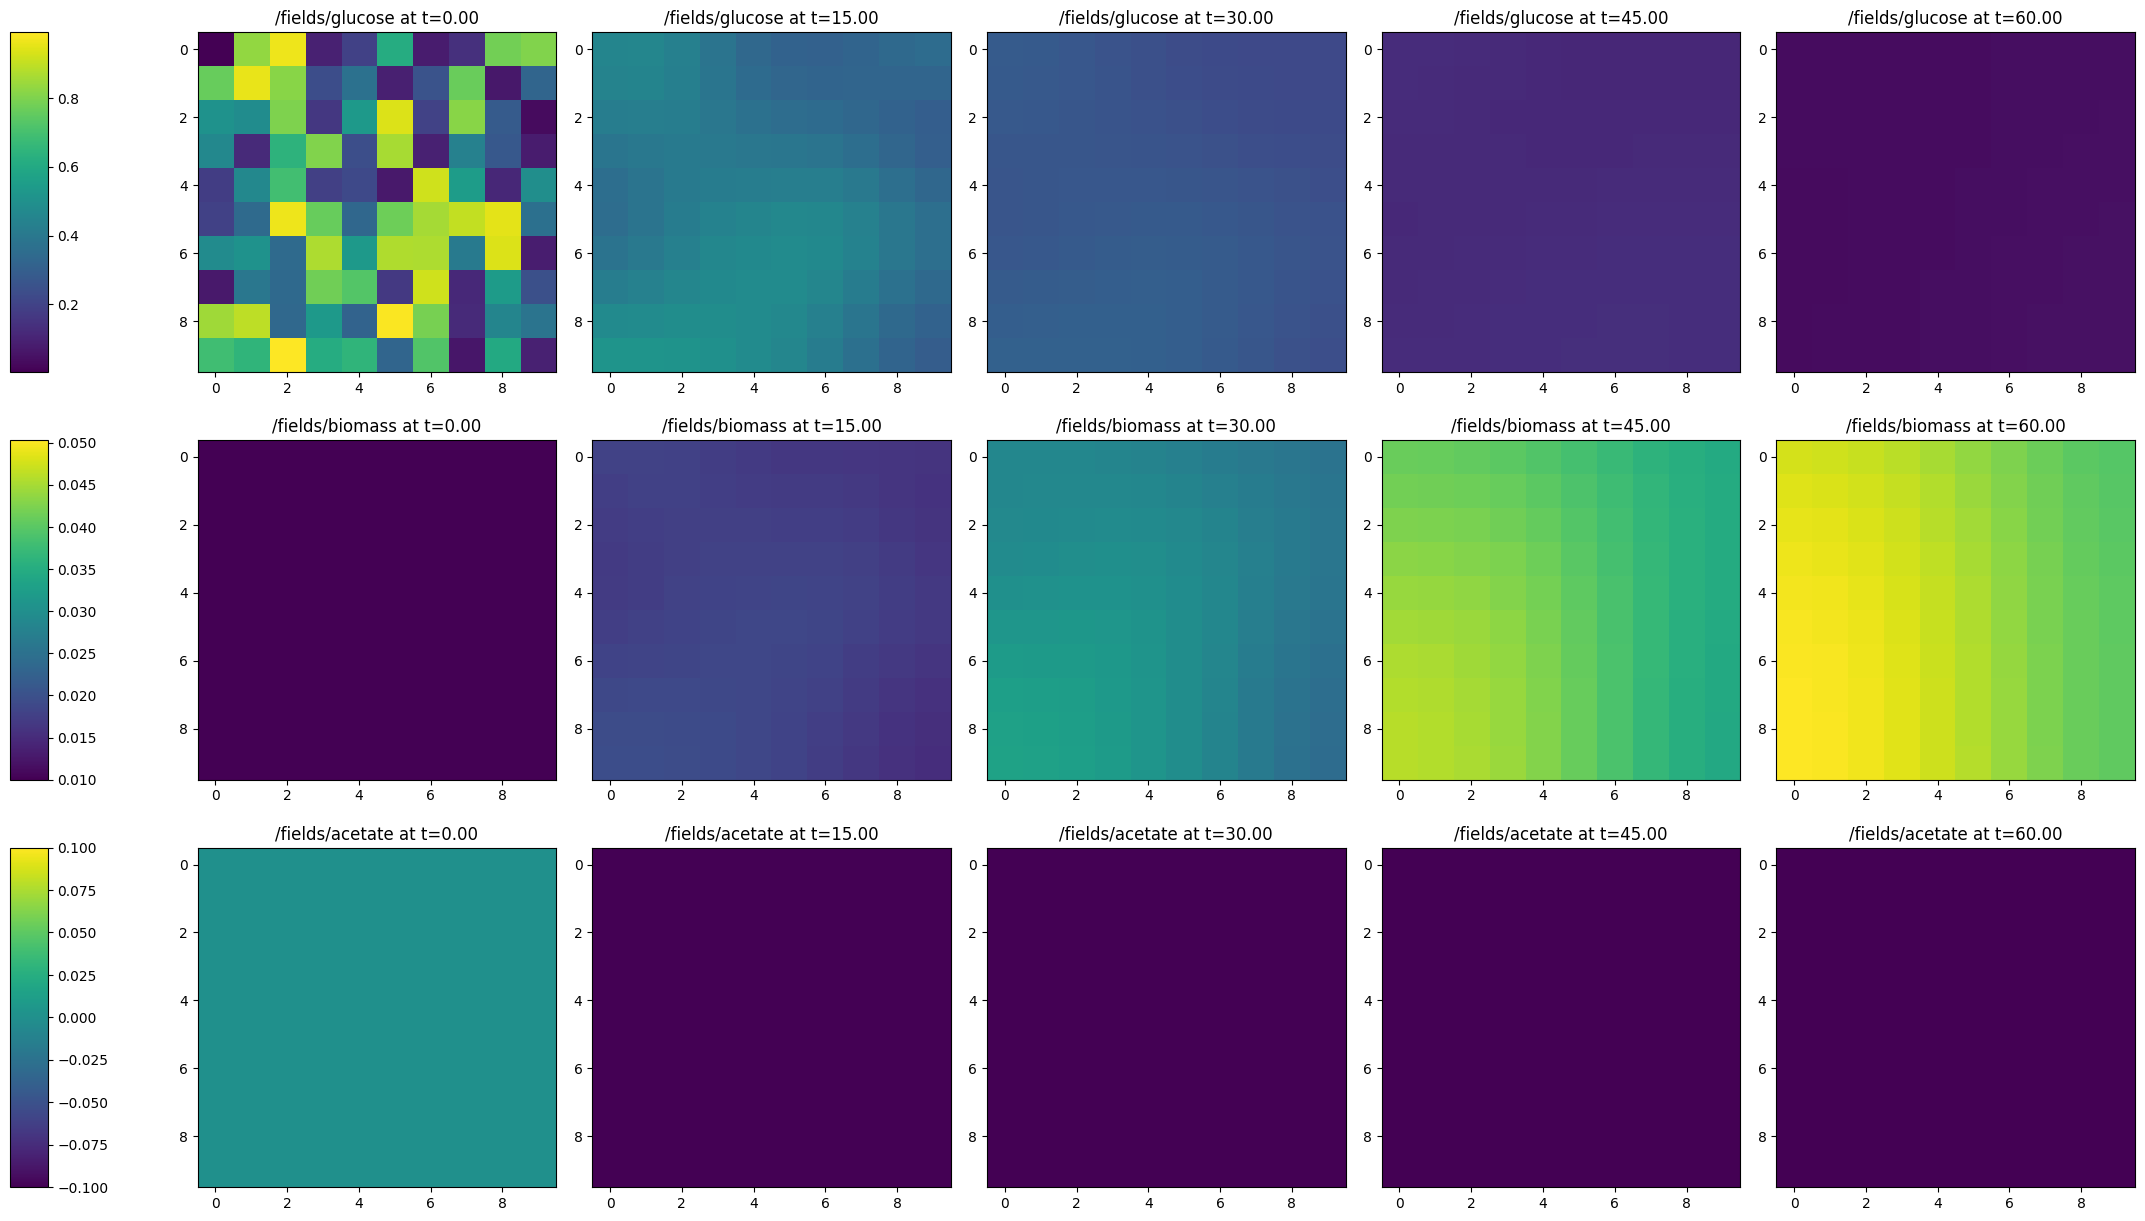

In [29]:
v4.plot_snapshots(n_snapshots=5)

In [30]:
# v4.show_video()

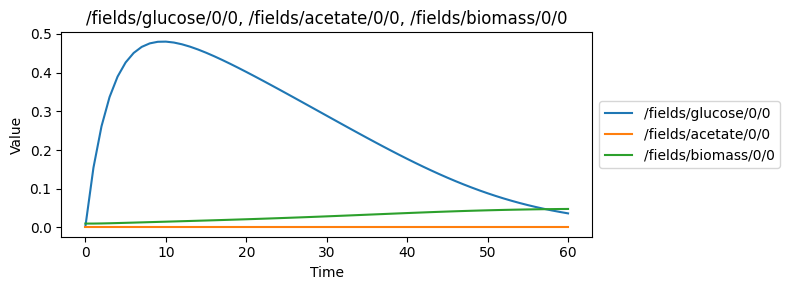

In [31]:
v4.plot_timeseries(
    subplot_size=(8, 3),
    query=[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0',
    ],
    combined_vars=[[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0',
    ]]
)

## Particles

In [38]:
bounds = (10.0, 20.0)  # Bounds of the environment
n_bins = (20, 40)  # Number of bins in the x and y directions

v5 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

v5.add_object(
    name='glucose',
    path=['fields'],
    value=np.random.rand(n_bins[0], n_bins[1])
)
# v5.add_object(
#     type='particle',  # TODO -- registered particle type?
#     path=['particles']
# )

v5.add_process(
    name='particle_movement',
    process_id='Particles',
    config={
        'n_bins': n_bins,
        'bounds': bounds,
        'diffusion_rate': 0.1,
        'advection_rate': (0, -0.1),
        'add_probability': 0.4,
        'boundary_to_add': ['top']
    },
)
v5.connect_process(
    name='particle_movement',
    inputs={
        'fields': ['fields'],
        'particles': ['particles']
    },
    outputs={
        'fields': ['fields'],
        'particles': ['particles']
    }
)

v5.initialize_process(
    name='particle_movement',
    config={'n_particles': 20}
)

# v5.add_emitter()

v5.diagram(dpi='70')

KeyboardInterrupt: 

In [33]:
v5.run(10)